In [ ]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from skimage import io
import cvlib as cv
from cvlib.object_detection import draw_bbox
from itertools import islice
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
import math
plt.style.use('ggplot')

In [244]:
train = pd.read_csv('train_bbox.csv')

In [267]:
image_num = 857
image_id = train['ImageId'][image_num]
image = '../images/train_images/' + image_id + '.jpg'
image_label = train['PredictionString'][image_num]
image_label

'[(37.0, 0.166139, 0.0258202, -3.07427, -13.8822, 4.93031, 23.2984), (28.0, 0.166909, 0.0120454, -3.12193, -13.2586, 6.11781, 30.407), (60.0, 0.151878, 0.0201949, -3.08381, -16.5498, 8.39212, 43.5314), (31.0, 0.150731, -2.97827, -3.11621, -17.4389, 9.18947, 50.8068), (16.0, 0.15073, 1.02857, -3.1162, 18.4789, 8.37417, 38.5961), (6.0, 0.150748, 0.237532, -3.11631, -5.40079, 16.1821, 86.6866), (16.0, 0.166139, 0.00398171, -3.07427, -5.98687, 2.7064, 9.10161), (16.0, 0.166136, -2.92128, -3.07427, -24.4967, 6.67378, 34.9595), (61.0, 0.164933, -0.464459, -3.07135, -27.004, 9.08091, 47.9804), (16.0, 0.164933, 0.13942, -3.07135, -16.8031, 6.70966, 34.7393), (16.0, 0.150731, 0.0334115, -3.11621, -9.67967, 6.61106, 33.5143), (16.0, 0.15073, 1.41406, -3.11621, 19.9935, 8.51007, 37.2369)]'

# Box & Center

In [ ]:
def find_cars(imageid):
    # Object Detection
    image = '../images/train_images/' + imageid + '.jpg'
    image_viz = io.imread(image)
    bbox, label, conf = cv.detect_common_objects(image_viz)
    
    # Select only cars
    cars = bbox, label, conf
    cars = [(bbox[n],label[n],conf[n]) for n in range(len(bbox)) if label[n] == 'car']
    cars = np.array(cars).transpose()
    output_image = draw_bbox(image_viz, cars[0], cars[1], cars[2])
    plt.figure(figsize=(15,15))
    plt.imshow(output_image)
    
    # Find centers
    bbox = np.array([x for x in cars[0]])
    if len(bbox) == 0:
        car_x = 0
        car_y = 0
    else:
        car_x = (bbox[:,0] + bbox[:,2]) / 2
        car_y = (bbox[:,1] + bbox[:,3]) / 2
    
    print(car_x)
        
    deltaY = car_x- 2305.8757
    deltaX = car_y - 2304.5479
    angle = np.arctan(deltaY / deltaX) * 180 / math.pi
    print(angle)
    
    #car_x_lane = [car_x[i] for i in range(len(car_x)) if (angle[i] < 90) & (angle[i] > 20)]
    #car_y_lane = [car_y[i] for i in range(len(car_y)) if (angle[i] < 90) & (angle[i] > 20)]
    
    x1 = 1100
    x2 = 2100
    x3 = 1700
    y1 = 2400
    y2 = 2400
    y3 = 1700
    
    vertices = np.array([[1100, 2400], [2100, 2400], [1700, 1700]], np.int32)
    pts = vertices.reshape((-1, 1, 2))

#     car_x_lane = []
#     car_y_lane = []
    
#     for x,y in car_x, car_y:
#         A = area (x1, y1, x2, y2, x3, y3) 
#         A1 = area (x, y, x2, y2, x3, y3) 
#         A2 = area (x1, y1, x, y, x3, y3) 
#         A3 = area (x1, y1, x2, y2, x, y)
#         if (A == A1 + A2 + A3):
#             car_x_lane.append(x)
#             car_y_lane.append(y)
    
#     car_x_lane = [car_x[i] for i in range(len(car_x)) if (A == A1 + A2 + A3)]
#     car_y_lane = [car_y[i] for i in range(len(car_y)) if (A == A1 + A2 + A3)] 
    
    cv2.polylines(output_image, [pts], isClosed=True, color=(0, 250, 25), thickness=10)
    plt.imshow(output_image)
    
    plt.scatter(x = car_x, y = car_y, color='orange', s=50)
    plt.scatter(x = car_x_lane, y = car_y_lane, color='red', s=50)
    plt.show()
    
    return bbox

#image_num = 557
find_cars(image_id)

# Data

In [128]:
# INPUT
sample_size = 100

# Import
train_og = pd.read_csv('../data/train.csv')
train = pd.read_csv('train_bbox.csv')
#train = train.sample(sample_size)
#train['bbox'] = [find_cars(n) for n in train['ImageId']]
train = train.merge(train_og, on = 'ImageId')
train = train.drop(['Unnamed: 0', 'cars', 'PredictionString_x'], axis = 1)
train.columns = ['ImageId', 'bbox', 'PredictionString']
train['bbox'] = [x.replace('[','') for x in train['bbox']]
train['bbox'] = [x.replace(']','') for x in train['bbox']]
train['bbox'] = [x.replace('  ',' ') for x in train['bbox']]
train['bbox'] = [x.split('\n') for x in train['bbox']]
train['bbox'] = train.apply(lambda x : [i.split(' ') for i in x['bbox']], axis = 1)
train['bbox'] = train.apply(lambda x : [list(filter(None, i)) for i in x['bbox']], axis = 1)
train['bbox'] = train.apply(lambda x : [int(i) for b in x['bbox'] for i in b], axis = 1)
train['bbox'] = [list(chunk(x, 4)) for x in train['bbox']]

# Split Prediction String
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

#col_names = ['model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']

train['PredictionString'] = [list(map(float, x)) for x in train['PredictionString'].str.split(" ")]
train['PredictionString'] = [list(chunk(x, 7)) for x in train['PredictionString']]
train['cars'] = [len(x) for x in train['PredictionString']]
# train

# Row per Car
per_car = pd.concat([train[['ImageId','cars','bbox']], train['PredictionString'].apply(pd.Series)], axis=1)
cols = [x for x in range(per_car['cars'].max())]
per_car = pd.melt(per_car, id_vars=['ImageId','cars','bbox'], value_vars=cols)
per_car = per_car.dropna(axis = 0)
per_car = per_car.drop('variable', axis = 1)
per_car = pd.concat([per_car[['ImageId', 'cars','bbox']], per_car['value'].apply(pd.Series)], axis = 1)
per_car.columns = ['ImageId', 'cars', 'bbox', 'model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']

#camera matrix
fx = 2304.5479
fy = 2305.8757
cx = 1686.2379
cy = 1354.9849

camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

def xyz_to_xy(row):
    hc = np.dot(camera_matrix, np.array([row[7], row[8], row[9]]))
    xy = hc[:-1] / hc[-1]
    return np.int16(xy)

per_car['img_x'] = [xyz_to_xy(per_car.loc[n])[0] for n in per_car.index]
per_car['img_y'] = [xyz_to_xy(per_car.loc[n])[1] for n in per_car.index]

# Split Bbox
per_car['bbox'] = per_car.apply(lambda x : list(x['bbox']), axis = 1)
per_car['cars_detected'] = per_car.apply(lambda x : len(x['bbox']), axis = 1)
per_car = pd.concat([per_car[['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected','img_x','img_y']], per_car['bbox'].apply(pd.Series)], axis=1)
cols = [x for x in range(per_car['cars_detected'].max())]
per_car = pd.melt(per_car, id_vars=['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected', 'img_x','img_y'], value_vars=cols)
per_car = per_car.dropna(axis = 0)
per_car = per_car.drop('variable', axis = 1)
per_car = pd.concat([per_car[['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected', 'img_x','img_y']], per_car['value'].apply(pd.Series)], axis = 1)

per_car.columns = ['ImageId', 'cars', 'model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'cars_detected', 'img_x','img_y', 'box_x1', 'box_y1', 'box_x2', 'box_y2']
per_car['match'] = np.where((per_car['box_x1'] < per_car['img_x']) & (per_car['img_x'] < per_car['box_x2']) & (per_car['box_y1'] < per_car['img_y']) & (per_car['img_y'] < per_car['box_y2']), True, False)
per_car['width'] = per_car.apply(lambda x : x['box_x2'] - x['box_x1'], axis = 1)
per_car['height'] = per_car.apply(lambda x : x['box_y2'] - x['box_y1'], axis = 1)
per_car['yaw_class'] = pd.cut(per_car['pitch'], bins = 9, labels = False)

matches = per_car[per_car['match'] == True]

In [116]:
per_car.shape

(507958, 20)

# Yaw Models

In [118]:
label = 'yaw_class'

box_yaw = matches[[label, 'box_x1', 'box_y1', 'width', 'height', 'model']]
y = box_yaw[label]
x = box_yaw.drop(label, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = KNeighborsClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.6319691577698695

In [120]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.602024 (0.003474)
LDA: 0.598837 (0.003587)
KNN: 0.625526 (0.007194)
DT: 0.577553 (0.005766)
NB: 0.607290 (0.008256)


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

RF: 0.658192 (0.007394)


In [123]:
label = 'pitch'

box_yaw = matches[[label, 'box_x1', 'box_y1', 'width', 'height', 'model']]
y = box_yaw[label]
x = box_yaw.drop(label, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0853534703116396
Mean Squared Error: 2.9208210926478655
Root Mean Squared Error: 1.7090409862399045


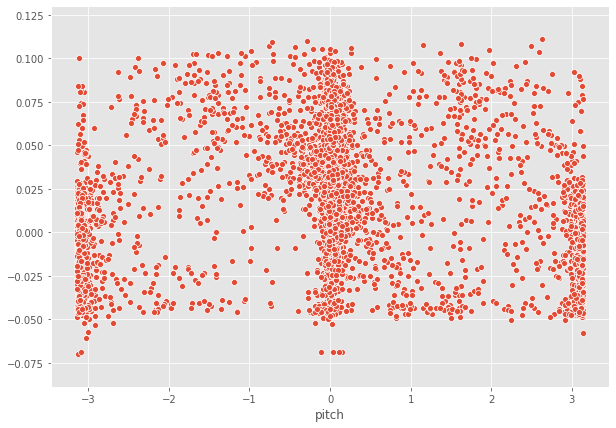

In [115]:
plt.figure(figsize = (10,7))
#sns.heatmap(box_yaw.corr(), annot = True)
sns.scatterplot(x = y_test, y = y_pred)

# Distance

In [260]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


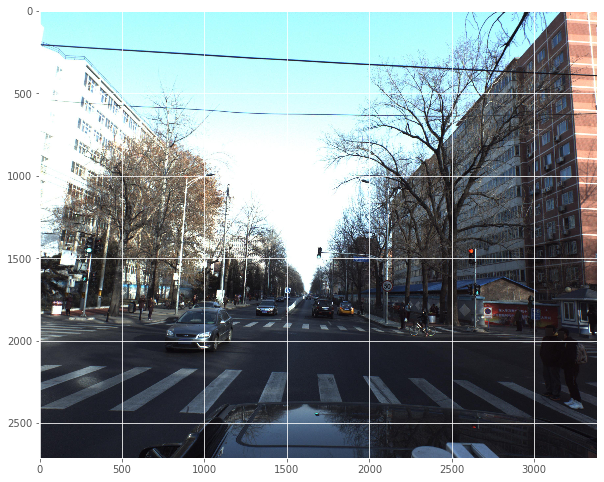

In [282]:
image_num = 179
image_id = train['ImageId'][image_num]
image = '../images/train_images/' + image_id + '.jpg'
image_label = train['PredictionString'][image_num]
image
image_viz = io.imread(image)
plt.figure(figsize = (10,10))
plt.imshow(image_viz)

In [ ]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
 


def distance_to_camera(knownWidth, focalLength, perWidth):
	# compute and return the distance from the maker to the camera
    return (knownWidth * focalLength) / perWidth

# loop over the images
for image_num in range(1,3):
	# load the image, find the marker in the image, then compute the
	# distance to the marker from the camera
    image_id = train['ImageId'][image_num]
    imagePath = '../images/train_images/' + image_id + '.jpg'
    image = cv2.imread(imagePath)
    bbox, label, conf = cv.detect_common_objects(image)
    
    # Select only cars
    cars = bbox, label, conf
    cars = [(bbox[n],label[n],conf[n]) for n in range(len(bbox)) if label[n] == 'car']
    cars = np.array(cars).transpose()
    #output_image = draw_bbox(image_viz, cars[0], cars[1], cars[2])
    fx = 2304.5479
    fy = 2305.8757
    marker = cars[0][0][1]
    inches = distance_to_camera(1.5, fx, marker)
 
	# draw a bounding box around the image and display it
    #box = cv2.cv.BoxPoints(marker) if imutils.is_cv2() else cv2.boxPoints(marker)
    #box = np.int0(box)
    #cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
    cv2.putText(image, "%.2fm" % (inches / 12),
        (image.shape[1] - 200, image.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX,
        2.0, (0, 255, 0), 3)
    #cv2.imshow("image", image)
    plt.imshow(image)
    #cv2.waitKey(0)


In [295]:
def find_marker(image):
	# convert the image to grayscale, blur it, and detect edges
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 35, 125)

	# find the contours in the edged image and keep the largest one;
	# we'll assume that this is our piece of paper in the image
	
    (cnts, _) = cv2.findContours(edged[0][0].copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key = cv2.contourArea)

	# compute the bounding box of the of the paper region and return it
    return cv2.minAreaRect(c)

find_marker(image_viz)

TypeError: image is not a numpy array, neither a scalar

# 3D Box

In [ ]:
dims = pd.read_csv('model_dim_id.csv')
per_car['model'] = per_car.apply(lambda x : int(x['model']), axis = 1)
per_car = per_car.merge(dims, left_on = 'model', right_on = 'id')

In [257]:
per_car.columns

Index(['ImageId', 'cars', 'model_x', 'yaw', 'pitch', 'roll', 'x', 'y', 'z',
       'cars_detected', 'img_x', 'img_y', 'box_x1', 'box_y1', 'box_x2',
       'box_y2', 'match', 'width_x', 'height_x', 'yaw_class', 'Unnamed: 0',
       'model_y', 'width_y', 'height_y', 'length', 'id'],
      dtype='object')

In [226]:
image_num = 7
image_id = train['ImageId'][image_num]
image_labels = train['PredictionString'][image_num]
image_id, image_labels

('ID_2803cf7b5',
 '[(8.0, 0.172028, 3.1064, -3.10087, -18.0211, 4.98543, 27.6988), (46.0, 0.197476, 1.13231, 3.14104, -19.2265, 6.54345, 37.0335), (28.0, 0.126736, 0.105196, 3.12778, 14.588, 5.88608, 24.632), (35.0, 0.112837, 0.0817151, 3.11517, 17.5575, 16.0402, 94.6429), (16.0, 0.197478, 3.1086, 3.14104, -19.3634, 7.87032, 44.6092), (66.0, 0.19271, 0.77389, -3.0982, -19.3459, 8.5851, 49.8995), (16.0, 0.112837, 0.207455, 3.11516, 7.41833, 11.2064, 64.5857), (16.0, 0.112837, -0.0252227, 3.11517, -0.525428, 6.42136, 34.8198), (18.0, 0.112951, 0.00758063, 3.11566, -1.23575, 13.4518, 83.0377), (2.0, 0.112951, 0.0215316, 3.11566, 2.68883, 15.2462, 95.1177)]')

In [239]:
def two_to_three(num):
    yaw = per_car.loc[num]['pitch']
    R_y = np.array([[math.cos(yaw), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]])
    
    h = per_car.loc[num]['height_y']
    w = per_car.loc[num]['width_y']
    l = per_car.loc[num]['length']

    # 3D bounding box corners
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

    # rotate and translate 3D bounding box
    corners_3D = R_y * np.array([x_corners, y_corners, z_corners]).transpose()
    print(corners_3D)
#     corners_3D(1,:) = corners_3D(1,:) + object.t(1)
#     corners_3D(2,:) = corners_3D(2,:) + object.t(2)
#     corners_3D(3,:) = corners_3D(3,:) + object.t(3)
                    
two_to_three(image_num)

ValueError: operands could not be broadcast together with shapes (3,3) (8,3) 

In [228]:
def calculate_XYZ(num):
    u = (per_car.loc[num]['box_x2'] + per_car.loc[num]['box_x1']) / 2
    v = (per_car.loc[num]['box_y2'] + per_car.loc[num]['box_y1']) / 2
    uv_1=np.array([[u,v,1]], dtype=np.float32)
    uv_1=uv_1.transpose()
    suv_1=self.scalingfactor*uv_1
    xyz_c=self.inverse_newcam_mtx.dot(suv_1)
    xyz_c=xyz_c-self.tvec1
    XYZ=self.inverse_R_mtx.dot(xyz_c)
    return XYZ

1.43852766

In [178]:
import math
n = 77
deltaY = per_car.loc[n]['img_y']- 2305.8757
deltaX = per_car.loc[n]['img_x'] - 2304.5479
angle = np.arctan(deltaY / deltaX) * 180 / math.pi
angle

22.364385920235563

In [167]:
#camera matrix
fx = 2304.5479
fy = 2305.8757
cx = 1686.2379
cy = 1354.9849

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
Ki = np.linalg.inv(K)
x = 3384/2
y = 2710/2
r = Ki.dot([x, y, 1])
r
#cos_angle = r1.dot(r2) / (np.linalg.norm(r1) * np.linalg.norm(r2))
#angle_radians = np.acos(cos_angle)

array([2.50031687e-03, 6.54848828e-06, 1.00000000e+00])

In [ ]:
def visualize(imageid):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = '../images/train_images/' + imageid + '.jpg'
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = per_car['x'], per_car['y'], per_car['z']
        yaw, pitch, roll = -per_car['pitch'], -per_car['yaw'], -per_car['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [ ]:
aafunction [corners_2D,face_idx] = computeBox3D(object,P)
# takes an object and a projection matrix (P) and projects the 3D
# bounding box into the image plane.

# # index for 3D bounding box faces
# face_idx = [ 1,2,6,5   % front face
#              2,3,7,6   % left face
#              3,4,8,7   % back face
#              4,1,5,8]; % right face

# compute rotational matrix around yaw axis
R_y = np.array([[math.cos(theta[1]), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]


numpy.linalg.pinv                
#3D bounding box dimensions
h = per_car['height_y']
w = per_car['width_y']
l = per_car['length_y']

# 3D bounding box corners
x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
y_corners = [0,0,0,0,-h,-h,-h,-h]
z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

# rotate and translate 3D bounding box
corners_3D = R_y * [x_corners, y_corners, z_corners]
corners_3D(1,:) = corners_3D(1,:) + object.t(1);
corners_3D(2,:) = corners_3D(2,:) + object.t(2);
corners_3D(3,:) = corners_3D(3,:) + object.t(3);

# project the 3D bounding box into the image plane
#corners_2D = projectToImage(corners_3D, P);

In [ ]:
def euler_to_rot(yaw, pitch, roll) :
    R_x = np.array([[1, 0, 0], [0, math.cos(pitch), -math.sin(pitch)], [0, math.sin(pitch), math.cos(pitch)]                 
    R_y = np.array([[math.cos(theta[1]), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]
    R_z = np.array([[math.cos(roll), -math.sin(roll), 0], [math.sin(roll), math.cos(roll), 0], [0, 0, 1]]
    R = np.dot(R_z, np.dot( R_y, R_x )) 
    return R

array([[2482, 1849, 2962, 2119],
       [2089, 1804, 2505, 2020],
       [3098, 1789, 3392, 1991],
       [ 769, 2366, 3191, 2692]])

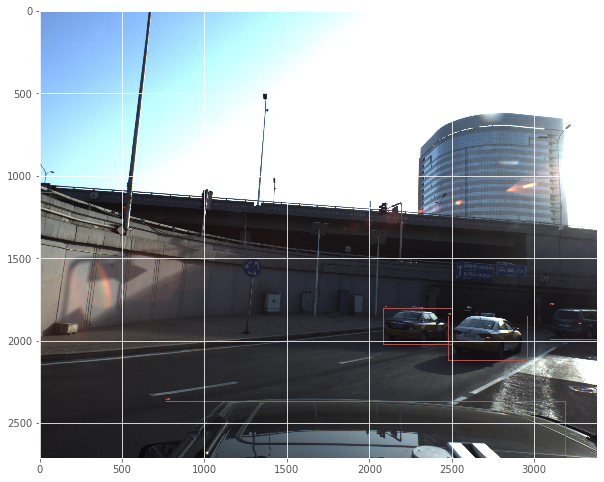

In [15]:
find_cars(image_id)

In [18]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[4][:2]), color, 16)

    cv2.line(image, tuple(points[1][:2]), tuple(points[5][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[4][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[7][:2]), color, 16)

    cv2.line(image, tuple(points[4][:2]), tuple(points[8][:2]), color, 16)
    cv2.line(image, tuple(points[5][:2]), tuple(points[8][:2]), color, 16)

    cv2.line(image, tuple(points[5][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[6][:2]), tuple(points[7][:2]), color, 16)
    cv2.line(image, tuple(points[7][:2]), tuple(points[8][:2]), color, 16)
    return image

def draw_points(image, points):
    image = np.array(image)
    for (p_x, p_y, p_z) in points:
        # print("p_x, p_y", p_x, p_y)
        cv2.circle(image, (p_x, p_y), 5, (255, 0, 0), -1)
    return image

def img_cor_2_world_cor():
    x_img, y_img, z_img = img_cor_points[0]
    xc, yc, zc = x_img*z_img, y_img*z_img, z_img
    p_cam = np.array([xc, yc, zc])
    xw, yw, zw = np.dot(np.linalg.inv(k), p_cam)
    print(xw, yw, zw)
    print(x, y, z)

for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    # I think the pitch and yaw should be exchanged
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.array([[0, 0, 0, 1],
                  [x_l, y_l, -z_l, 1],
                  [x_l, y_l, z_l, 1],
                  [-x_l, y_l, z_l, 1],
                  [-x_l, y_l, -z_l, 1],
                  [x_l, -y_l, -z_l, 1],
                  [x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, -z_l, 1]]).T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    # call this function before chage the dtype
    img_cor_2_world_cor()
    img_cor_points = img_cor_points.astype(int)
    img = draw_points(img, img_cor_points)
    img = draw_line(img, img_cor_points)
    
img = Image.fromarray(img)
plt.imshow(img)
plt.show()

NameError: name 'yaws' is not defined

In [ ]:
import numpy as np

# using this math: https://en.wikipedia.org/wiki/Rotation_matrix
def rotation_matrix(yaw, pitch=0, roll=0):
    tx = roll
    ty = yaw
    tz = pitch

    Rx = np.array([[1,0,0], [0, np.cos(tx), -np.sin(tx)], [0, np.sin(tx), np.cos(tx)]])
    Ry = np.array([[np.cos(ty), 0, np.sin(ty)], [0, 1, 0], [-np.sin(ty), 0, np.cos(ty)]])
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0], [np.sin(tz), np.cos(tz), 0], [0,0,1]])


    return Ry.reshape([3,3])
    # return np.dot(np.dot(Rz,Ry), Rx)

# option to rotate and shift (for label info)
def create_corners(dimension, location=None, R=None):
    dx = dimension[2] / 2
    dy = dimension[0] / 2
    dz = dimension[1] / 2

    x_corners = []
    y_corners = []
    z_corners = []

    for i in [1, -1]:
        for j in [1,-1]:
            for k in [1,-1]:
                x_corners.append(dx*i)
                y_corners.append(dy*j)
                z_corners.append(dz*k)

    corners = [x_corners, y_corners, z_corners]

    # rotate if R is passed in
    if R is not None:
        corners = np.dot(R, corners)

    # shift if location is passed in
    if location is not None:
        for i,loc in enumerate(location):
            corners[i,:] = corners[i,:] + loc

    final_corners = []
    for i in range(8):
        final_corners.append([corners[0][i], corners[1][i], corners[2][i]])


    return final_corners

# this is based on the paper. Math!
# calib is a 3x4 matrix, box_2d is [(xmin, ymin), (xmax, ymax)]
# Math help: http://ywpkwon.github.io/pdf/bbox3d-study.pdf
def calc_location(dimension, proj_matrix, box_2d, alpha, theta_ray):
    #global orientation
    orient = alpha + theta_ray
    R = rotation_matrix(orient)

    # format 2d corners
    xmin = box_2d[0][0]
    ymin = box_2d[0][1]
    xmax = box_2d[1][0]
    ymax = box_2d[1][1]

    # left top right bottom
    box_corners = [xmin, ymin, xmax, ymax]

    # get the point constraints
    constraints = []

    left_constraints = []
    right_constraints = []
    top_constraints = []
    bottom_constraints = []

    # using a different coord system
    dx = dimension[2] / 2
    dy = dimension[0] / 2
    dz = dimension[1] / 2

    # below is very much based on trial and error

    # based on the relative angle, a different configuration occurs
    # negative is back of car, positive is front
    left_mult = 1
    right_mult = -1

    # about straight on but opposite way
    if alpha < np.deg2rad(92) and alpha > np.deg2rad(88):
        left_mult = 1
        right_mult = 1
    # about straight on and same way
    elif alpha < np.deg2rad(-88) and alpha > np.deg2rad(-92):
        left_mult = -1
        right_mult = -1
    # this works but doesnt make much sense
    elif alpha < np.deg2rad(90) and alpha > -np.deg2rad(90):
        left_mult = -1
        right_mult = 1

    # if the car is facing the oppositeway, switch left and right
    switch_mult = -1
    if alpha > 0:
        switch_mult = 1

    # left and right could either be the front of the car ot the back of the car
    # careful to use left and right based on image, no of actual car's left and right
    for i in (-1,1):
        left_constraints.append([left_mult * dx, i*dy, -switch_mult * dz])
    for i in (-1,1):
        right_constraints.append([right_mult * dx, i*dy, switch_mult * dz])

    # top and bottom are easy, just the top and bottom of car
    for i in (-1,1):
        for j in (-1,1):
            top_constraints.append([i*dx, -dy, j*dz])
    for i in (-1,1):
        for j in (-1,1):
            bottom_constraints.append([i*dx, dy, j*dz])

    # now, 64 combinations
    for left in left_constraints:
        for top in top_constraints:
            for right in right_constraints:
                for bottom in bottom_constraints:
                    constraints.append([left, top, right, bottom])

    # filter out the ones with repeats
    constraints = filter(lambda x: len(x) == len(set(tuple(i) for i in x)), constraints)

    # create pre M (the term with I and the R*X)
    pre_M = np.zeros([4,4])
    # 1's down diagonal
    for i in range(0,4):
        pre_M[i][i] = 1

    best_loc = None
    best_error = [1e09]
    best_X = None

    # loop through each possible constraint, hold on to the best guess
    # constraint will be 64 sets of 4 corners
    count = 0
    for constraint in constraints:
        # each corner
        Xa = constraint[0]
        Xb = constraint[1]
        Xc = constraint[2]
        Xd = constraint[3]

        X_array = [Xa, Xb, Xc, Xd]

        # M: all 1's down diagonal, and upper 3x1 is Rotation_matrix * [x, y, z]
        Ma = np.copy(pre_M)
        Mb = np.copy(pre_M)
        Mc = np.copy(pre_M)
        Md = np.copy(pre_M)

        M_array = [Ma, Mb, Mc, Md]

        # create A, b
        A = np.zeros([4,3], dtype=np.float)
        b = np.zeros([4,1])

        indicies = [0,1,0,1]
        for row, index in enumerate(indicies):
            X = X_array[row]
            M = M_array[row]

            # create M for corner Xx
            RX = np.dot(R, X)
            M[:3,3] = RX.reshape(3)

            M = np.dot(proj_matrix, M)

            A[row, :] = M[index,:3] - box_corners[row] * M[2,:3]
            b[row] = box_corners[row] * M[2,3] - M[index,3]

        # solve here with least squares, since over fit will get some error
        loc, error, rank, s = np.linalg.lstsq(A, b, rcond=None)

        # found a better estimation
        if error < best_error:
            count += 1 # for debugging
            best_loc = loc
            best_error = error
            best_X = X_array

    # return best_loc, [left_constraints, right_constraints] # for debugging
    best_loc = [best_loc[0][0], best_loc[1][0], best_loc[2][0]]
    return best_loc, best_X